# Cybersecurity Data Analysis - EDA and Sampling

## Objective
The goal of this notebook is to prepare a manageable dataset for our analysis. The full "CIC IoT-DIAD 2024" dataset is extremely large (hundreds of GBs), which makes it impractical to process entirely in memory on a standard workstation.

## Strategy: Sampling
To overcome the size limitation, we are employing a **Uniform Random Sampling** strategy.

*   **Why**: To reduce RAM usage and processing time while preserving the statistical properties of the original data.
*   **How**: We iterate through every CSV file in the dataset and load only a random subset of rows (approximately 8-10%). This is achieved by generating a random number for each row and keeping it if the number is below our `SAMPLE_RATE` threshold. This ensures that every part of the dataset (every attack type, every file) is represented proportionally in our final subset.

## 1. Import Libraries

In [1]:
import pandas as pd
import os
import glob
import random
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

# Set random seed for reproducibility
random.seed(42)

# Define dataset roots
# FLOW_DATA_DIR = 'data/Anomaly Detection - Flow Based features/'
PACKET_DATA_DIR = 'data/Device Identification_Anomaly Detection - Packet Based Features/'
SAMPLE_RATE = 0.08

print("Libraries imported and paths defined.")

Libraries imported and paths defined.


In [2]:
def load_and_sample_data(root_dir, sample_rate=0.1):
    """
    Recursively finds all CSV files in the root_dir, reads a percentage of each,
    and returns a combined DataFrame.
    Detects if files have headers or not to ensure consistent column structure.
    """
    all_files = []
    for root, dirs, files in os.walk(root_dir):
        for file in files:
            if file.endswith(".csv"):
                all_files.append(os.path.join(root, file))
    
    print(f"Found {len(all_files)} CSV files in {root_dir}")
    
    if not all_files:
        return pd.DataFrame()

    # 1. Determine standard column names from a reliable reference file (e.g., Benign traffic)
    # Prefer a file with 'Benign' in name, else first file
    ref_file = next((f for f in all_files if "Benign" in f), all_files[0])
    print(f"Using {os.path.basename(ref_file)} as schema reference.")
    
    with open(ref_file, 'r') as f:
        header_line = f.readline().strip()
        ref_columns = header_line.split(',')
    
    print(f"Schema columns ({len(ref_columns)}): {ref_columns[:5]} ...")

    df_list = []
    
    # Common keywords to identify if a row is a header
    header_keywords = ['Flow ID', 'Src IP', 'src_mac', 'dst_ip', 'Protocol', 'stream']

    for file_path in all_files:
        try:
            # Check if file has a header
            with open(file_path, 'r', encoding='utf-8', errors='ignore') as f:
                first_line = f.readline().strip()
            
            has_header = any(k in first_line for k in header_keywords)
            
            if has_header:
                # File has header: treat row 0 as header (and replace names), skip logic applies to rows > 0
                header_arg = 0
                skip_condition = lambda i: i > 0 and random.random() > sample_rate
            else:
                # File has NO header: treat row 0 as data, skip logic applies to all rows
                header_arg = None
                skip_condition = lambda i: random.random() > sample_rate

            df_chunk = pd.read_csv(
                file_path, 
                header=header_arg,
                names=ref_columns,  # Force consistent column names
                skiprows=skip_condition,
                on_bad_lines='skip'
            )
            
            # Extract Label Info
            # Structure: root/MainClass/SubClass/file.csv
            rel_path = os.path.relpath(file_path, root_dir)
            path_parts = rel_path.split(os.sep)
            
            if len(path_parts) >= 2:
                main_category = path_parts[0]
                # If structure is root/Category/File.csv, sub is same as main or None
                # If root/Category/Type/File.csv -> sub is Type
                sub_category = path_parts[-2] if len(path_parts) > 1 else main_category
            else:
                main_category = "Unknown"
                sub_category = "Unknown"

            df_chunk['Main_Label'] = main_category
            df_chunk['Sub_Label'] = sub_category
            df_chunk['Source_File'] = os.path.basename(file_path)
            
            df_list.append(df_chunk)
            
        except Exception as e:
            print(f"Error reading {file_path}: {e}")
            
    if df_list:
        combined_df = pd.concat(df_list, ignore_index=True)
        return combined_df
    else:
        return pd.DataFrame()

print("Function defined.")

Function defined.


In [3]:
# Load Flow-Based Data
# print("Loading Flow-Based Dataset...")
# df_flow = load_and_sample_data(FLOW_DATA_DIR, SAMPLE_RATE)
# print(f"Total Flow Data Shape: {df_flow.shape}")

# Load Packet-Based Data
print("\nLoading Packet-Based Dataset...")
df_packet = load_and_sample_data(PACKET_DATA_DIR, SAMPLE_RATE)
print(f"Total Packet Data Shape: {df_packet.shape}")


Loading Packet-Based Dataset...
Found 180 CSV files in data/Device Identification_Anomaly Detection - Packet Based Features/
Using BenignTraffic.csv as schema reference.
Schema columns (135): ['stream', 'src_mac', 'dst_mac', 'src_ip', 'dst_ip'] ...


/tmp/ipykernel_106710/3097977959.py:73: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_chunk['Main_Label'] = main_category
/tmp/ipykernel_106710/3097977959.py:74: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_chunk['Sub_Label'] = sub_category
/tmp/ipykernel_106710/3097977959.py:75: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame,

Total Packet Data Shape: (2855439, 138)


Flow Data Info:
<class 'pandas.DataFrame'>
RangeIndex: 2226541 entries, 0 to 2226540
Data columns (total 86 columns):
 #   Column                      Dtype 
---  ------                      ----- 
 0   Flow ID                     object
 1   Src IP                      object
 2   Src Port                    object
 3   Dst IP                      object
 4   Dst Port                    object
 5   Protocol                    object
 6   Timestamp                   object
 7   Flow Duration               object
 8   Total Fwd Packet            object
 9   Total Bwd packets           object
 10  Total Length of Fwd Packet  object
 11  Total Length of Bwd Packet  object
 12  Fwd Packet Length Max       object
 13  Fwd Packet Length Min       object
 14  Fwd Packet Length Mean      object
 15  Fwd Packet Length Std       object
 16  Bwd Packet Length Max       object
 17  Bwd Packet Length Min       object
 18  Bwd Packet Length Mean      object
 19  Bwd Packet Length Std       object
 2

,Flow ID,Src IP,Src Port,Dst IP,Dst Port,Protocol,Timestamp,Flow Duration,Total Fwd Packet,Total Bwd packets,...,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Main_Label,Sub_Label,Source_File
0,192.168.137.41-157.249.81.141-46012-443-6,192.168.137.41,46012,157.249.81.141,443,6,03/10/2022 02:17:00 PM,272772,3,4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Web-Based,sqlinjection,SqlInjection.pcap_Flow.csv
1,192.168.137.41-157.249.81.141-46024-443-6,192.168.137.41,46024,157.249.81.141,443,6,03/10/2022 02:17:07 PM,270352,3,4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Web-Based,sqlinjection,SqlInjection.pcap_Flow.csv
2,192.168.137.41-157.249.81.141-47677-80-6,192.168.137.41,47677,157.249.81.141,80,6,03/10/2022 02:17:08 PM,336328,3,4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Web-Based,sqlinjection,SqlInjection.pcap_Flow.csv
3,192.168.137.41-109.95.152.66-58590-443-6,192.168.137.41,58590,109.95.152.66,443,6,03/10/2022 02:17:12 PM,269617,9,5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Web-Based,sqlinjection,SqlInjection.pcap_Flow.csv
4,192.168.137.41-157.249.81.141-46061-443-6,192.168.137.41,46061,157.249.81.141,443,6,03/10/2022 02:17:24 PM,287558,3,4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Web-Based,sqlinjection,SqlInjection.pcap_Flow.csv



Flow Data Description:


,Flow ID,Src IP,Src Port,Dst IP,Dst Port,Protocol,Timestamp,Flow Duration,Total Fwd Packet,Total Bwd packets,...,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Main_Label,Sub_Label,Source_File
count,2226541,2226541,2226541,2226541,2226541,2226541,2226541,2226541,2226541,2226541,...,2226541.0,2226541.0,2226541.0,2226541.0,2226541.0,2226541.0,2226541.0,2226541,2226541,2226541
unique,1753169,2416,65536,4472,65171,3,165390,1902538,1412,679,...,472264.0,654482.0,613306.0,1642836.0,1436796.0,1499948.0,1191878.0,8,17,128
top,8.6.0.1-8.0.6.4-0-0-0,192.168.137.182,4070,192.168.137.182,6668,6,10/08/2022 10:16:07 AM,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,DoS,DoS SYN Flood,DoS-SYN_Flood.pcap_Flow.csv
freq,307,744530,100172,150499,496738,1723316,1715,7207,435428,1334012,...,1743581.0,1481705.0,1481705.0,490978.0,775919.0,490978.0,490978.0,1853537,1304003,319234


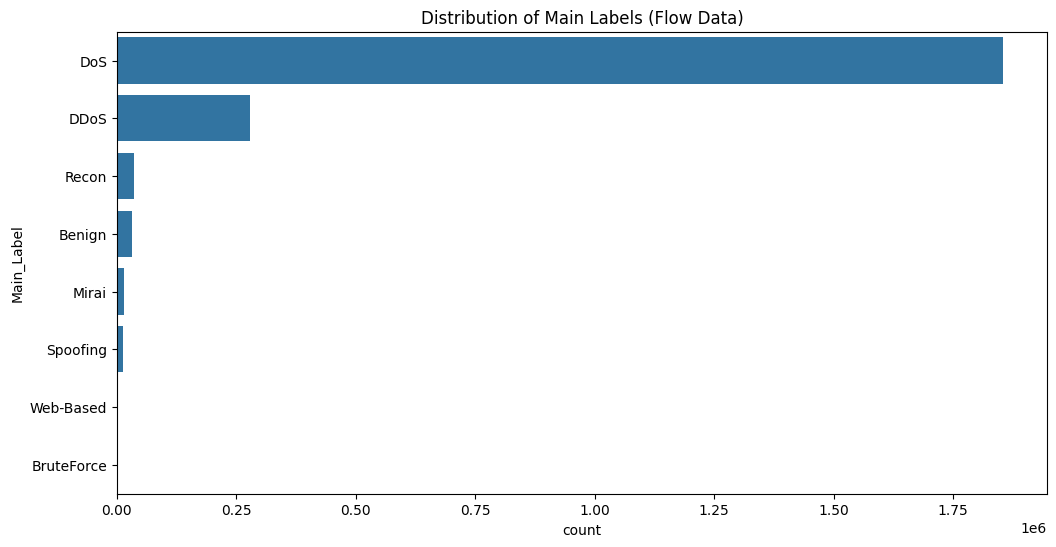

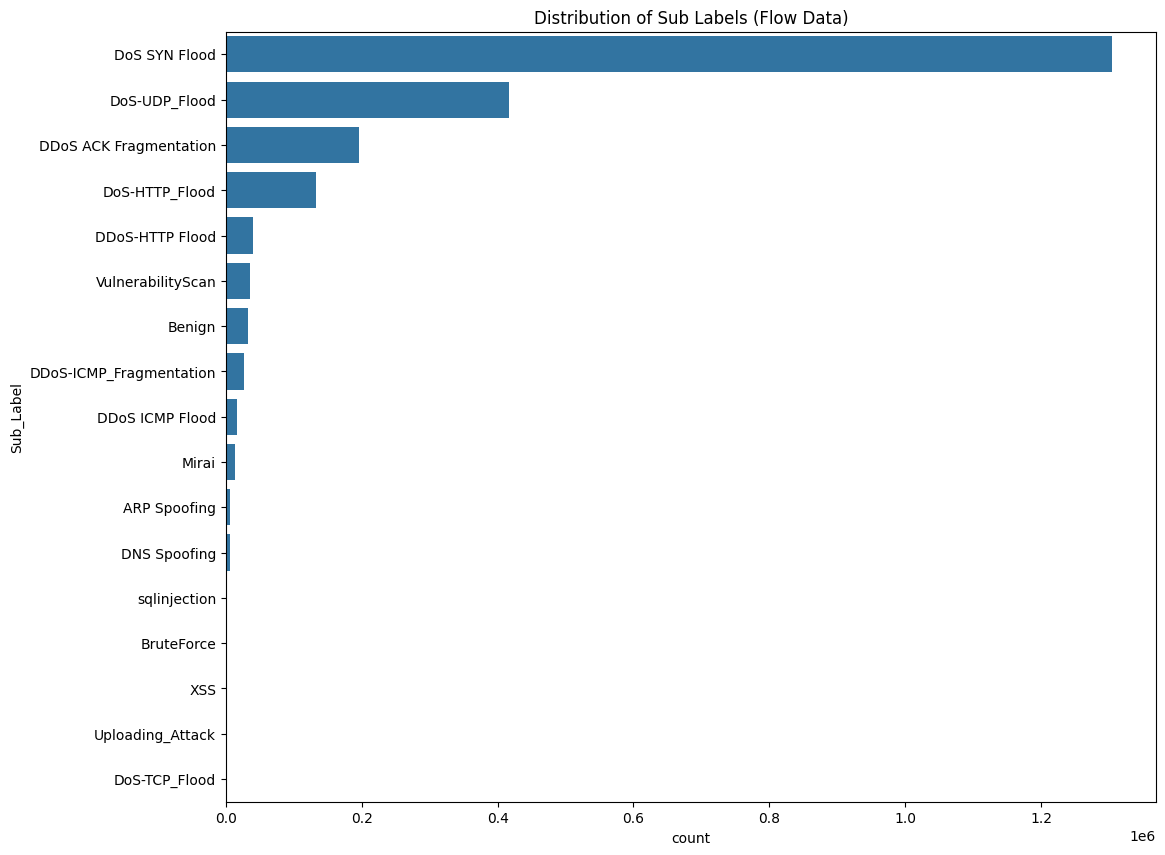

In [5]:
# EDA - Flow Based Features
df_flow.drop(columns=['Label'], inplace=True)
print("Flow Data Info:")
print(df_flow.info())
print("\nFlow Data Head:")
display(df_flow.head())
print("\nFlow Data Description:")
display(df_flow.describe())

# Check Label Distribution
plt.figure(figsize=(12, 6))
sns.countplot(y='Main_Label', data=df_flow, order = df_flow['Main_Label'].value_counts().index)
plt.title('Distribution of Main Labels (Flow Data)')
plt.show()

if 'Sub_Label' in df_flow.columns:
    plt.figure(figsize=(12, 10))
    sns.countplot(y='Sub_Label', data=df_flow, order = df_flow['Sub_Label'].value_counts().index)
    plt.title('Distribution of Sub Labels (Flow Data)')
    plt.show()

Packet Data Info:
<class 'pandas.DataFrame'>
RangeIndex: 2855439 entries, 0 to 2855438
Columns: 138 entries, stream to Source_File
dtypes: float64(97), int64(22), object(1), str(18)
memory usage: 2.9+ GB
None

Packet Data Head:


,stream,src_mac,dst_mac,src_ip,dst_ip,src_port,dst_port,inter_arrival_time,time_since_previously_displayed_frame,port_class_dst,...,med_p,average_p,var_p,q3_p,q1_p,iqr_p,l3_ip_dst_count,Main_Label,Sub_Label,Source_File
0,0,Arlo Q Indoor Camera,3c:18:a0:41:c3:a0,192.168.137.175,99.81.244.93,56891,443,0.000164,0.000164,1,...,2908.0,2908.00,0.000000e+00,2908.0,2908.0,0.0,1.0,BenignTraffic,BenignTraffic,BenignTraffic.csv
1,0,Arlo Q Indoor Camera,3c:18:a0:41:c3:a0,192.168.137.175,99.81.244.93,56891,443,0.008173,0.000098,1,...,2908.0,2497.85,7.909834e+05,2908.0,1460.0,1448.0,1.0,BenignTraffic,BenignTraffic,BenignTraffic.csv
2,0,Arlo Q Indoor Camera,3c:18:a0:41:c3:a0,192.168.137.175,99.81.244.93,56891,443,0.019489,0.000006,1,...,2908.0,2787.45,2.056292e+06,2908.0,1460.0,1448.0,1.0,BenignTraffic,BenignTraffic,BenignTraffic.csv
3,1,Teckin Plug 2,ff:ff:ff:ff:ff:ff,192.168.137.82,255.255.255.255,49236,6667,0.122046,0.002378,2,...,172.0,172.00,0.000000e+00,172.0,172.0,0.0,1.0,BenignTraffic,BenignTraffic,BenignTraffic.csv
4,0,Arlo Q Indoor Camera,3c:18:a0:41:c3:a0,192.168.137.175,99.81.244.93,56891,443,0.506371,0.000153,1,...,1460.0,2181.70,2.494912e+06,2908.0,1460.0,1448.0,1.0,BenignTraffic,BenignTraffic,BenignTraffic.csv



Packet Data Description:


,stream,src_port,dst_port,inter_arrival_time,time_since_previously_displayed_frame,port_class_dst,l4_tcp,l4_udp,ttl,eth_size,...,sum_p,min_p,max_p,med_p,average_p,var_p,q3_p,q1_p,iqr_p,l3_ip_dst_count
count,2.855439e+06,2.855439e+06,2.855439e+06,2.855439e+06,2.855439e+06,2.855439e+06,2.855439e+06,2.855439e+06,2.855439e+06,2.855439e+06,...,2.855439e+06,2.855439e+06,2.855439e+06,2.855439e+06,2.855439e+06,2.855439e+06,2.855439e+06,2.855439e+06,2.855439e+06,2.855439e+06
mean,4.806234e+04,2.610114e+04,1.740781e+04,4.308398e+03,1.072668e-02,1.515071e+00,3.335543e-01,4.023486e-01,6.909126e+01,5.153610e+02,...,4.648785e+03,9.158936e+01,4.514318e+02,2.178439e+02,2.324393e+02,1.113147e+05,3.300888e+02,1.200765e+02,2.100123e+02,1.997522e+01
std,7.757466e+04,2.272808e+04,2.116437e+04,4.340490e+04,1.095079e+01,1.036126e+00,4.714827e-01,4.903716e-01,3.351424e+01,6.050308e+02,...,6.954543e+03,2.101631e+02,8.965913e+02,3.683086e+02,3.477271e+02,4.532385e+05,5.273436e+02,2.703181e+02,4.793871e+02,3.309905e+01
min,-1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e-06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.200000e+01,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
25%,-1.000000e+00,0.000000e+00,0.000000e+00,1.178122e+01,1.000000e-06,0.000000e+00,0.000000e+00,0.000000e+00,6.400000e+01,6.000000e+01,...,1.200000e+02,0.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,0.000000e+00,6.000000e+00,0.000000e+00,0.000000e+00,2.000000e+00
50%,5.540000e+02,2.833100e+04,6.668000e+03,5.175845e+01,1.200000e-05,2.000000e+00,0.000000e+00,0.000000e+00,6.400000e+01,3.620000e+02,...,5.520000e+02,6.000000e+00,1.020000e+02,1.800000e+01,2.760000e+01,0.000000e+00,2.000000e+01,6.000000e+00,0.000000e+00,3.000000e+00
75%,6.988300e+04,4.724900e+04,3.522900e+04,1.754618e+02,2.790000e-04,2.000000e+00,1.000000e+00,1.000000e+00,6.400000e+01,5.780000e+02,...,1.072000e+04,1.800000e+01,5.360000e+02,5.360000e+02,5.360000e+02,2.667789e+04,5.360000e+02,1.800000e+01,1.122500e+02,1.400000e+01
max,2.992110e+05,6.553500e+04,6.553500e+04,5.802446e+05,1.625967e+04,3.000000e+00,1.000000e+00,1.000000e+00,2.550000e+02,2.033800e+04,...,1.073920e+05,2.908000e+03,3.476400e+04,5.190000e+03,5.369600e+03,5.627513e+07,1.304400e+04,4.356000e+03,1.303200e+04,1.880000e+02


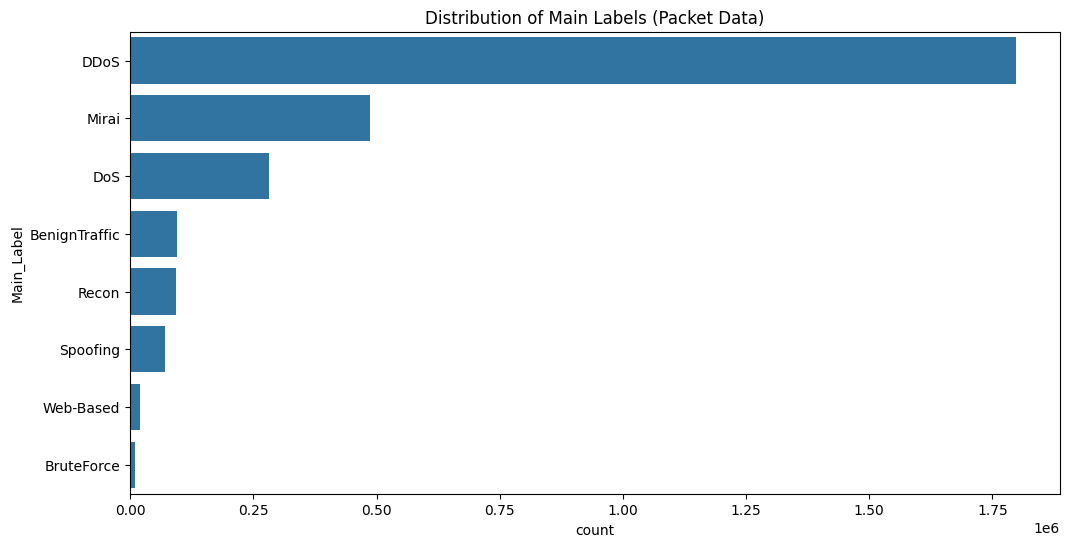

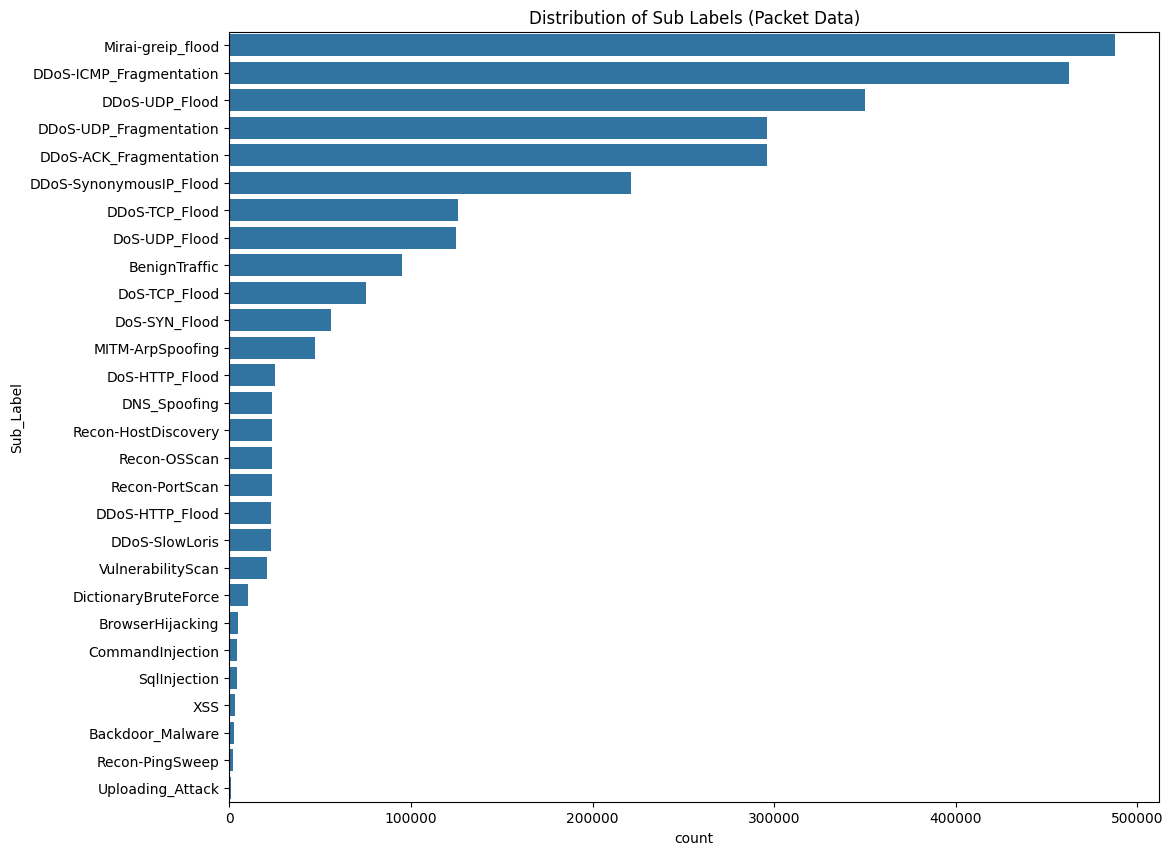

In [4]:
# EDA - Packet Based Features
print("Packet Data Info:")
print(df_packet.info())
print("\nPacket Data Head:")
display(df_packet.head())
print("\nPacket Data Description:")
display(df_packet.describe())

# Check Label Distribution
plt.figure(figsize=(12, 6))
sns.countplot(y='Main_Label', data=df_packet, order = df_packet['Main_Label'].value_counts().index)
plt.title('Distribution of Main Labels (Packet Data)')
plt.show()

if 'Sub_Label' in df_packet.columns:
    plt.figure(figsize=(12, 10))
    sns.countplot(y='Sub_Label', data=df_packet, order = df_packet['Sub_Label'].value_counts().index)
    plt.title('Distribution of Sub Labels (Packet Data)')
    plt.show()

In [5]:
# Missing Values Analysis
print("Missing Values in Flow Data:")
print(df_flow.isnull().sum()[df_flow.isnull().sum() > 0])

# print("\nMissing Values in Packet Data:")
# print(df_packet.isnull().sum()[df_packet.isnull().sum() > 0])

Missing Values in Flow Data:
Flow Bytes/s                                   6988
35.185.101.66-192.168.137.72-443-33777-6    2226541
35.185.101.66                               2226541
443                                         2226541
192.168.137.72                              2226541
                                             ...   
1.0.1                                       2226541
96                                          2226541
3.604118786949726.1                         2226541
3.1                                         2226541
2025                                        2226541
Length: 205, dtype: int64
Flow Bytes/s                                   6988
35.185.101.66-192.168.137.72-443-33777-6    2226541
35.185.101.66                               2226541
443                                         2226541
192.168.137.72                              2226541
                                             ...   
1.0.1                                       2226541
96       

,Flow ID,Src IP,Src Port,Dst IP,Dst Port,Protocol,Timestamp,Flow Duration,Total Fwd Packet,Total Bwd packets,...,832380.0,832381.0,416190.5.1,588580.8354172773.1,832380.0.1,1.0.1,96,3.604118786949726.1,3.1,2025
0,192.168.137.41-157.249.81.141-46012-443-6,192.168.137.41,46012.0,157.249.81.141,443.0,6.0,03/10/2022 02:17:00 PM,272772.0,3.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,192.168.137.41-157.249.81.141-46024-443-6,192.168.137.41,46024.0,157.249.81.141,443.0,6.0,03/10/2022 02:17:07 PM,270352.0,3.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,192.168.137.41-157.249.81.141-47677-80-6,192.168.137.41,47677.0,157.249.81.141,80.0,6.0,03/10/2022 02:17:08 PM,336328.0,3.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,192.168.137.41-109.95.152.66-58590-443-6,192.168.137.41,58590.0,109.95.152.66,443.0,6.0,03/10/2022 02:17:12 PM,269617.0,9.0,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,192.168.137.41-157.249.81.141-46061-443-6,192.168.137.41,46061.0,157.249.81.141,443.0,6.0,03/10/2022 02:17:24 PM,287558.0,3.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
# Save to Pickle
flow_pkl_path = 'flow_data_8percent.pkl'
packet_pkl_path = 'packet_data_8percent.pkl'

# df_flow.to_pickle(flow_pkl_path)
# print(f"Saved sampled flow data to {flow_pkl_path}")

df_packet.to_pickle(packet_pkl_path)
print(f"Saved sampled packet data to {packet_pkl_path}")

Saved sampled packet data to packet_data_8percent.pkl
